# NYC Yellow Taxi Growth

#### The objectives of this program:
Using the data set that comes from NYC open data of **NYC Yellow Taxi Service** and **Uber Taxi Service** we would like to **analyze the growth** of the NYC Yellow Taxi Service by using the amount of pickups done daily.

We will be using correlation between taxi and uber in respective borough to observe the **correlation between the growth rate** of both taxi and uber to help understand how competition impacts pickup amounts. We will also use statistics to help **predict the growth** done within the next few days. We will be using **histograms and line charts** to demonstrate the growth.

In [2]:
sc

In [1]:
# imports
import csv
import pandas as pd
import numpy as np
import scipy
import datetime
import fiona
import pyproj
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point


## Taxi vs Uber

In [3]:
taxi_aug14 = sc.textFile('../yellow_tripdata_2014-08.csv', use_unicode=False).filter(lambda x: x != "").cache()
uber_aug14 = sc.textFile('../uber-raw-data-aug14.csv', use_unicode=False).cache()
boro_shape = fiona.open('../nyu_2451_34490/nyu_2451_34490.shp')
# list(enumerate(taxi_aug14.first().split(',')))
# list(enumerate(uber_aug14.first().split(',')))

### Borough Estimation

We will be using pyproj to get the a coordinate (lon, lat) and project it to a map with (x,y) coordinates. We want to be able to import coodinates and find the borough, given our shapes.

In [163]:
lboro = ['Bronx', 'Brooklyn','Manhattan', 'Queens', 'Staten Island']
boro_range = [[],[],[],[],[]]
for i in range(5):
    boro_range[i] = shape(boro_shape[i]['geometry'])
def getlocation(x):
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    gLoc = Point(proj(float(x[0]) , float(x[1])))
    for i in range(len(boro_range)):
        if(gLoc.within(boro_range[i])):
            return lboro[i]

### Data Ingestion for August 2014 Taxi Data

We will clean the data into:  
```((boro, pickup, 1)```  
Then we will group this data as:  
```[boro [(date, count)]]```

In [12]:
def extractTaxi(partId, records):
    if partId==0:
        records.next()
    reader = csv.reader(records)
    for row in reader:
        (pickup, boro) = (row[1].split(" ")[0], getlocation((row[5],row[6])))
        if boro in ['Bronx', 'Brooklyn','Manhattan', 'Queens', 'Staten Island']:
            yield ((boro, pickup) , 1)
trdd = taxi_aug14.mapPartitionsWithIndex(extractTaxi)\
                .reduceByKey(lambda x, y: x+y)\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
                .reduceByKey(lambda x, y: (x+y)) \
                .sortBy(lambda x:(x[0]))
#trdd.take(10)

### Data Ingestion for August 2014 Uber Data

Just like the taxi data, we will format the Uber data just the same.

In [64]:
def extractUber(partId, records):
    if partId==0:
        records.next()
    reader = csv.reader(records)
    for row in reader:
        (pickup, boro) = (row[0].split(" ")[0],  getlocation((row[2],row[1])))
        if boro in ['Bronx', 'Brooklyn', 'Queens', 'Manhattan', 'Staten Island']:
            yield ((boro, pickup) , 1)

urdd = uber_aug14.mapPartitionsWithIndex(extractUber)\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: ((x[0][0], datetime.datetime.strptime(x[0][1], "%m/%d/%Y").strftime("%Y-%m-%d")), x[1]))\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (x[0][0], [(x[0][1], x[1])]))\
                .reduceByKey(lambda x, y: (x+y)) \
                .sortBy(lambda x:(x[0]))
#urdd.take(10)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 1424.0 failed 1 times, most recent failure: Lost task 1.0 in stage 1424.0 (TID 589, localhost, executor driver): java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(Unknown Source)
	at java.net.SocketOutputStream.write(Unknown Source)
	at java.io.BufferedOutputStream.flushBuffer(Unknown Source)
	at java.io.BufferedOutputStream.write(Unknown Source)
	at java.io.DataOutputStream.write(Unknown Source)
	at java.io.FilterOutputStream.write(Unknown Source)
	at org.apache.spark.api.python.PythonRDD$.writeUTF(PythonRDD.scala:674)
	at org.apache.spark.api.python.PythonRDD$.org$apache$spark$api$python$PythonRDD$$write$1(PythonRDD.scala:494)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:504)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:504)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:504)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:328)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1951)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:269)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1925)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1965)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor72.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketException: Connection reset by peer: socket write error
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(Unknown Source)
	at java.net.SocketOutputStream.write(Unknown Source)
	at java.io.BufferedOutputStream.flushBuffer(Unknown Source)
	at java.io.BufferedOutputStream.write(Unknown Source)
	at java.io.DataOutputStream.write(Unknown Source)
	at java.io.FilterOutputStream.write(Unknown Source)
	at org.apache.spark.api.python.PythonRDD$.writeUTF(PythonRDD.scala:674)
	at org.apache.spark.api.python.PythonRDD$.org$apache$spark$api$python$PythonRDD$$write$1(PythonRDD.scala:494)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:504)
	at org.apache.spark.api.python.PythonRDD$$anonfun$writeIteratorToStream$1.apply(PythonRDD.scala:504)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:504)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:328)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1951)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:269)


##### This function will get data from either of the dataset

In [16]:
# gets data given a key
def get_data(data, i):
    # returns ALL values
    if i == -1:
        return data.values().map(lambda x: list(zip(*x)[1])).collect()
    # returns ALL dates
    if i == -2:
        return data.values().map(lambda x: zip(*x)[0]).collect()
    # returns all days
    if i == -3:
        return data.values().map(lambda x: zip(*x)[0]) \
            .map(lambda dates : map(lambda date: int(datetime.datetime.strptime(date, "%Y-%m-%d").strftime("%d")), dates)).collect()
    return list(data.values().zipWithIndex().filter(lambda (key,index) : index == i).map(lambda x: zip(*x[0])[1]).collect()[0])
# don't use index 2 in the actual database because it is 'outside_nyc'
lboro = urdd.map(lambda x: x[0]).collect()
nboro = len(trdd.map(lambda x: x[0]).collect())

### Scatter Line Graph for Taxi vs Uber

We want to first normalize our data as we obviously know that the Yellow New York Taxi has a sample size greater than Uber. We do this by dividing each frequency by the total accumilation of frequencies.  
We also want to do a bar shift to make a bar graph side by side.

In [153]:
def normalize(data):
    total = float(sum(data))
    if total:
        return [y / total for y in data]
    return data

def bar_shift(data):
    return [x+.3 for x in data]

def make_bar(tx, ty, ux, uy, title):
    plt.bar(tx, ty, width=0.3, color='b', label='taxi')
    plt.bar(ux, uy, width=0.3, color='r', label='uber')
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('days')
    plt.ylabel('pickups ratio')
    plt.tight_layout()
    plt.show()

#### We will first make a scatter to observe the data

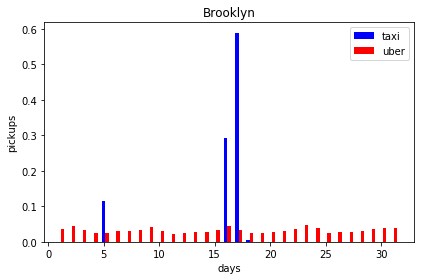

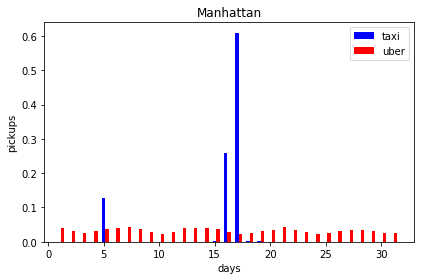

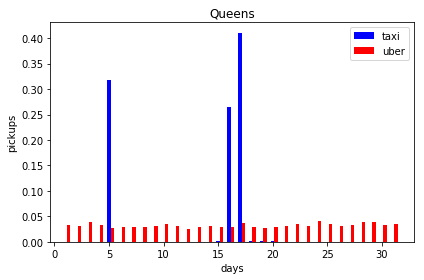

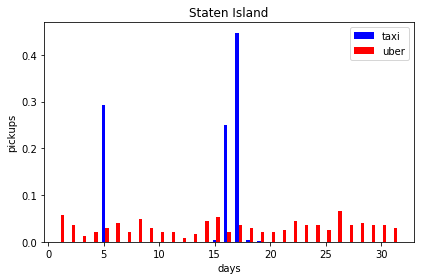

IndexError: list index out of range

In [154]:
for i in range(nboro):
    make_bar(get_data(trdd, -3)[i], normalize(get_data(trdd, i)),
             bar_shift(get_data(urdd, -3)[i]), normalize(get_data(urdd, i)), lboro[i])

### Cumilative Line Graph for Taxi vs Uber

In [161]:
def get_vb(key):
    # evaluate the histogram
    tvb = list(np.histogram(normalize(get_data(trdd, key)), bins=31))
    uvb = list(np.histogram(normalize(get_data(urdd, key)), bins=31))
   
    #evaluate the cumulative
    tvb[0] = np.cumsum(tvb[0])
    uvb[0] = np.cumsum(uvb[0])
    
    return tvb, uvb

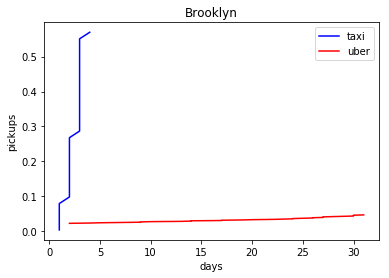

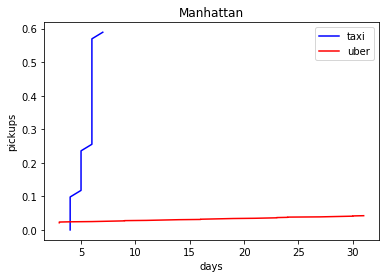

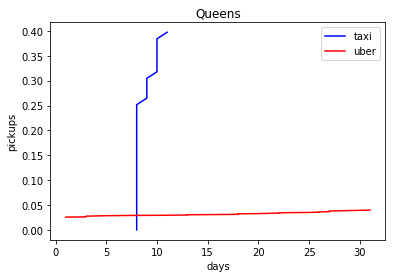

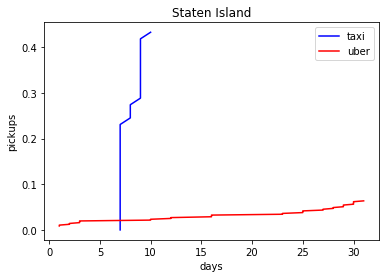

IndexError: list index out of range

In [162]:
# plot the cumulative functions
def make_accum_graph(tvb, uvb, key):
        plt.plot(tvb[0], tvb[1][:-1], c='blue', label = 'taxi')
        plt.plot(uvb[0], uvb[1][:-1], c='red', label = 'uber')
        plt.title(lboro[key])
        plt.legend(loc='best')
        plt.xlabel('days')
        plt.ylabel('pickups ratio')
        plt.show()
    
for i in range(nboro):
    tvb, uvb = get_vb(i)
    make_accum_graph(tvb, uvb, i)

## Growth Rate Comparison

Then we will make growth rate comparison using histograph of boro based in seperate squares to get a better idea of increase and decrease correlation for both statistics.

In [157]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [158]:
def get_growth(data, key):
    data = sc.parallelize(data.collect()[key][1])
    df = sqlc.createDataFrame(data, ["date", "value"])
    my_window = Window.partitionBy().orderBy("date")

    df = df.withColumn("prev_value", F.lag(df.value).over(my_window))
    df = df.withColumn("diff", F.when(F.isnull(((df.value - df.prev_value)/df.prev_value)*100), 0)
                                  .otherwise((df.value - df.prev_value)/df.prev_value)*100)
    return df.rdd.map(lambda x: x.date.encode("utf-8")).collect(), df.rdd.map(lambda x: x.diff).collect()

In [159]:
def make_growth_chart(tx, ty, ux, uy, title):
    plt.plot(tx, ty,'-o', c ='blue', label = 'taxi')
    plt.plot(ux, uy, '-o', c='red', label = 'uber')
    plt.axhline(linewidth=3, ls = 'dashed')
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('days')
    plt.ylabel('pickups ratio')
    plt.show()

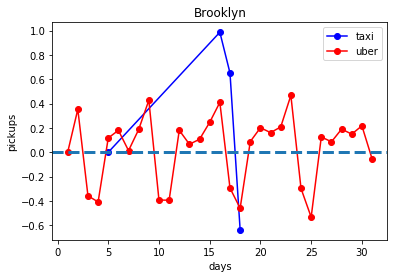

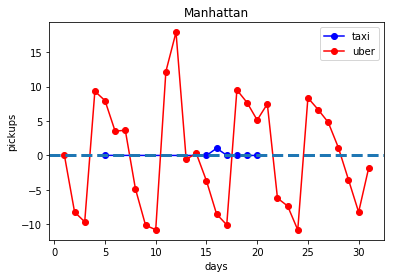

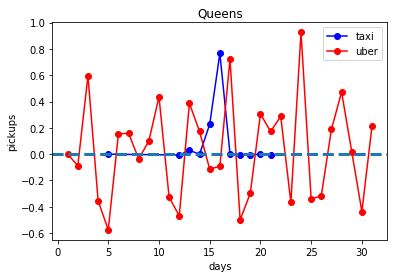

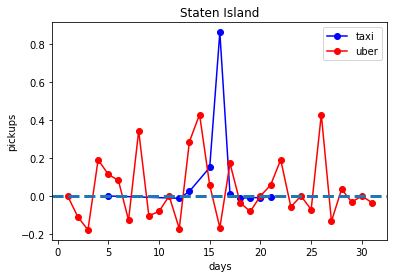

ZeroDivisionError: float division by zero

In [160]:
for i in range(nboro):
    make_growth_chart(get_data(trdd, -3)[i], normalize(get_growth(trdd, i)[1]), 
                      get_data(urdd, -3)[i], normalize(get_growth(urdd, i)[1]), lboro[i])

### Coefficient Correlation

In [113]:
def make_coeff(slope, intercept, x, y, key):
    plt.plot(x, y, 'o', label = 'uber/taxi')
    plt.plot(x, intercept+ slope*x, '-', label = 'correlation' )
    plt.title(lboro[key])
    plt.legend(loc='best')
    plt.xlabel('taxi')
    plt.ylabel('uber')
    plt.show()

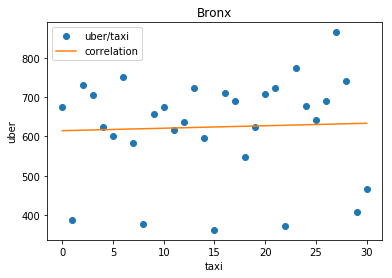

r-value:  0.04385010944169656
p-value:  0.8148091341111183


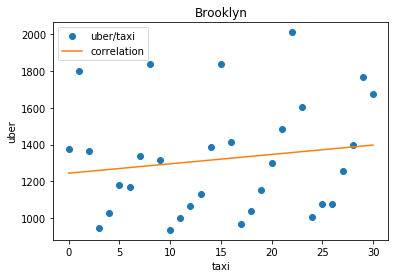

r-value:  0.15255411042034883
p-value:  0.41261967537038646


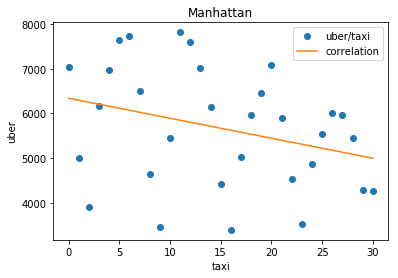

r-value:  -0.30570094425346656
p-value:  0.09443872057298337


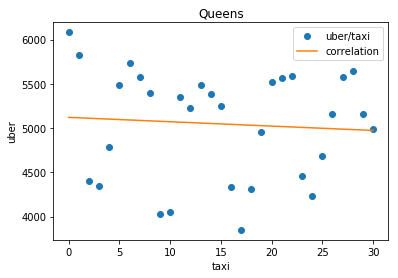

r-value:  -0.07296507610543553
p-value:  0.6964785915734157


In [114]:
from scipy import stats
import numpy as np

l = list(range(len(get_data(urdd, 0))))

for i in range(nboro):
    #x = scipy.array(get_data(trdd, i))
    x = scipy.array(l)
    y = scipy.array(get_data(urdd, i))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    make_coeff(slope, intercept, x, y, i)
    print 'r-value: ', r_value
    print 'p-value: ', p_value

## Prediction

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

In [116]:
columns = ['boro', 'days_in_month', 'number_of_pickup']
dic_boro = {'bronx': 0, 'brooklyn': 1, 'manhattan': 2,  'queens': 3, 'staten': 4}

In [ ]:
if not internet_on():
    print 'internet not on!!!'
    sys.exit()

Urdd_table = uber_aug14.mapPartitionsWithIndex(extractUber)\
                .reduceByKey(lambda x, y: x+y)\
                .map(lambda x: ((x[0][0], datetime.datetime.strptime(x[0][1], "%m/%d/%Y").strftime("%Y-%m-%d")), x[1]))\
                .sortBy(lambda x:(x[0][0], x[0][1]))\
                .map(lambda x: (dic_boro[x[0][0]], int(datetime.datetime.strptime(x[0][1], "%Y-%m-%d").strftime("%d")),x[1]))
                               # (x[1]-min_boro[dic_boro[x[0][0]]])/(max_boro[dic_boro[x[0][0]]]- min_boro[dic_boro[x[0][0]]])))

In [ ]:
Urdd_table.take(10)

In [ ]:
df_urdd = Urdd_table.collect()
'''df = pd.DataFrame(Urdd_table.collect(), columns=columns)
df_boro = [[],[],[],[],[],[]]
for i in range(6):
    for j in range(len(df)):
        if df['boro'][j] == i:
            df_boro[i].append(df.loc[j].values)
'''


In [ ]:
df_boro = [[],[],[],[],[],[]]
for i in range(nboro):
    for item in df_urdd:
        if item[0] == i:
            df_boro[i].append(item)
for i in range(6):
    df_boro[i] = pd.DataFrame(df_boro[i], columns=columns)

In [ ]:
X = [[],[],[],[],[],[]]
y =[[],[],[],[],[],[]]
X_train=[[],[],[],[],[],[]]
X_test=[[],[],[],[],[],[]]
y_train=[[],[],[],[],[],[]] 
y_test=[[],[],[],[],[],[]]

for i in range(nboro):
    X[i] = df_boro[i][['boro', 'days_in_month']].values
    y[i] = df_boro[i][['number_of_pickup']].values
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size=0.4, random_state=1)
    print(X_train[i].shape, X_test[i].shape)

### Training each prediction

In [ ]:
linear_r = LinearRegression()
lasso_r = Lasso()
ridge_r = Ridge(alpha=1.0)
elastic_r = ElasticNet(alpha=1, l1_ratio=0.5)

In [ ]:
for i in range(nboro):
    linear_r.fit(X_train[i], y_train[i])
    lasso_r.fit(X_train[i], y_train[i])
    ridge_r.fit(X_train[i], y_train[i])
    elastic_r.fit(X_train[i], y_train[i])
    print(lboro(i), lasso_r.predict(df_boro[i][['boro', 'days_in_month']].values))